# Building a WaveNet

Continues from Part 3

In [40]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random

In [41]:
words = open('names.txt', 'r').read().splitlines()

In [42]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(itos)

In [43]:
block_size = 3

def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])


In [44]:
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 # Kaiming init
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None: 
            self.out += self.bias # Wx + b if there's b
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
        
class BatchNorm1d:  
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps # epsilon
        self.momentum = momentum
        self.training = True # behaviours of certain attributes vary for training and inference
        # batchnorm trainable params
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers for running momentum update
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        # forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True) # batch mean
            xvar = x.var(0, keepdim=True) # batch variance
        else: # in inference, we use the accummuldated mean and var of the whole training set
            xmean = self.running_mean 
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        # update buffers - only updated during training
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 -self.momentum) * self.running_var + self.momentum * xvar
        return self.out
        
    def parameters(self):
        return [self.gamma, self.beta] 
    
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []
    

In [45]:
torch.manual_seed(42)

In [46]:
n_embd = 10
n_hidden = 200

C = torch.randn((vocab_size, n_embd))
layers = [ # ignore the formatting, it's just a list with elements
    Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
]

# we init before training
with torch.no_grad():
    # make softmax (last layer) less confident
    layers[-1].weight *= 0.1


parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

12097


In [47]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # Construct the minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    emb = C[Xb] # embed chars into a vector
    x = emb.view(emb.shape[0], -1) # concat the vectors
    # new forward pass for layers
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)

    # backward pass
    for layer in layers:
        layer.out.retain_grad() # for debugging. retains the graphs
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.2966
  10000/ 200000: 2.2322
  20000/ 200000: 2.4111
  30000/ 200000: 2.1004
  40000/ 200000: 2.3157
  50000/ 200000: 2.2104
  60000/ 200000: 1.9653
  70000/ 200000: 1.9767
  80000/ 200000: 2.6738
  90000/ 200000: 2.0837
 100000/ 200000: 2.2730
 110000/ 200000: 1.7087
 120000/ 200000: 2.3243
 130000/ 200000: 2.2512
 140000/ 200000: 2.0113
 150000/ 200000: 1.8195
 160000/ 200000: 1.7985
 170000/ 200000: 2.2206
 180000/ 200000: 2.0566
 190000/ 200000: 2.1030


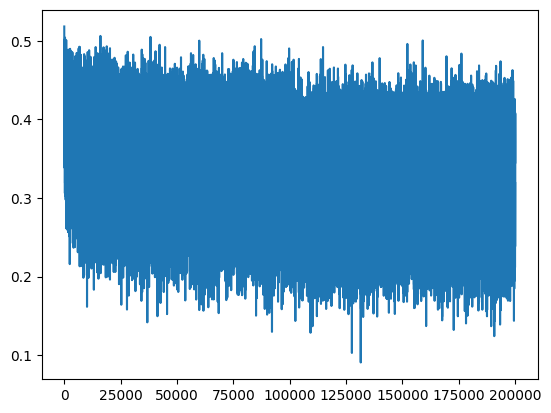

In [48]:
plt.plot(lossi)

In [49]:
# put layers in eval mode
for layer in layers:
    layer.training = False

In [50]:
# evalyate the loss
@torch.no_grad() # disable gradient tracking automatically setting requires_grad to false
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr), 
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    emb = C[x] 
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, y)
    print(split, loss.item())
split_loss('train')
split_loss('val')

train 2.0621414184570312
val 2.109346389770508


In [51]:
for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        # forward pass the neural net
        emb = C[torch.tensor([context])]
        x = emb.view(emb.shape[0], -1)
        for layer in layers:
            x = layer(x)
        logits = x
        probs = F.softmax(logits, dim=1)
        # sample from distribution
        ix = torch.multinomial(probs, num_samples=1).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)

        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

ivon.
fanili.
thoommasamiel.
emmadery.
andr.
aleigh.
kelynnie.
jazul.
carleen.
jah.
jorra.
alaya.
shonan.
vishylaharia.
juna.
vio.
orven.
meriell.
laiye.
zefina.


Making the loss look nicer. We need to average up some of the loss values to get a more representative value along the way <br>
We form a tensor of 1000 cols 

In [52]:
torch.tensor(lossi).view(-1, 1000).shape

torch.Size([200, 1000])

and we can get the mean

In [53]:
torch.tensor(lossi).view(-1, 1000).mean(1)

tensor([0.4059, 0.3791, 0.3698, 0.3681, 0.3657, 0.3639, 0.3624, 0.3593, 0.3557,
        0.3561, 0.3516, 0.3515, 0.3504, 0.3501, 0.3491, 0.3477, 0.3498, 0.3474,
        0.3494, 0.3449, 0.3456, 0.3440, 0.3452, 0.3461, 0.3429, 0.3456, 0.3458,
        0.3438, 0.3408, 0.3437, 0.3435, 0.3407, 0.3424, 0.3412, 0.3415, 0.3404,
        0.3419, 0.3391, 0.3414, 0.3396, 0.3392, 0.3408, 0.3394, 0.3416, 0.3389,
        0.3390, 0.3376, 0.3407, 0.3364, 0.3376, 0.3393, 0.3362, 0.3371, 0.3349,
        0.3393, 0.3369, 0.3363, 0.3349, 0.3338, 0.3386, 0.3366, 0.3388, 0.3370,
        0.3379, 0.3349, 0.3378, 0.3325, 0.3358, 0.3353, 0.3390, 0.3369, 0.3366,
        0.3354, 0.3350, 0.3375, 0.3347, 0.3352, 0.3352, 0.3318, 0.3359, 0.3348,
        0.3338, 0.3350, 0.3367, 0.3331, 0.3333, 0.3346, 0.3356, 0.3339, 0.3339,
        0.3332, 0.3331, 0.3352, 0.3356, 0.3350, 0.3335, 0.3330, 0.3299, 0.3344,
        0.3350, 0.3232, 0.3178, 0.3209, 0.3222, 0.3227, 0.3220, 0.3193, 0.3218,
        0.3200, 0.3176, 0.3221, 0.3187, 

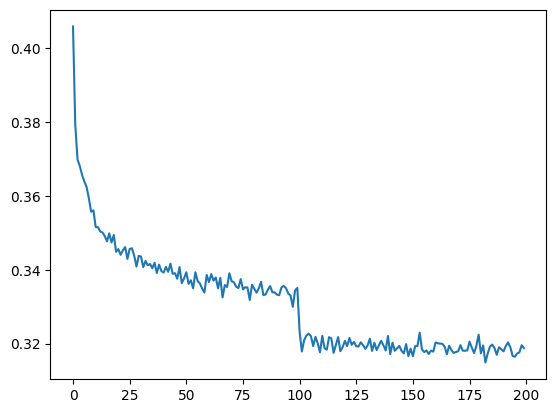

In [54]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

# Cleaning up the Layers code <br>
Embedding does the indexing while Flatten does the flatten operation

In [55]:
# to be added close to the other classes
class Embedding:
    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim))
    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out
    def parameters(self):
        return [self.weight]
    
class Flatten:
    def __call__(self, x):
        self.out = x.view(x.shape[0], -1)
        return self.out
    def parameters(self):
        return []

In [56]:
n_embd = 10
n_hidden = 200

layers = [
    Embedding(vocab_size, n_embd),
    Flatten(),
    Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
]

with torch.no_grad():
    # make softmax (last layer) less confident
    layers[-1].weight *= 0.1


parameters = [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

12097


In [57]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # Construct the minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    # the embedding and flattening have been moved into the layers
    x = Xb
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)

    # backward pass
    for layer in layers:
        layer.out.retain_grad() # for debugging. retains the graphs
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

    break

      0/ 200000: 3.2763


# Sequential Layer

Our code currently puts our layers into a primitive list. In PyTorch, this is usually done using a Sequential layer. <br>
The layer essentially takes a list of layers, and when you get an input in the forward pass, it calls the layers sequentially and returns the result

In [58]:
class Sequential:
    def __init__(self, layers):
        self.layers = layers

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [59]:
n_embd = 10
n_hidden = 200

model = Sequential([
    Embedding(vocab_size, n_embd),
    Flatten(),
    Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
])

with torch.no_grad():
    # make softmax (last layer) less confident
    layers[-1].weight *= 0.1


parameters = model.parameters()
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

12097


... and we improve the forward pass code

In [60]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # Construct the minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)

    # backward pass
    for layer in layers:
        layer.out.retain_grad() # for debugging. retains the graphs
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

    break

      0/ 200000: 3.6890


and then eval

In [61]:
for layer in model.layers:
    layer.training = False

In [62]:
# evalyate the loss
@torch.no_grad() # disable gradient tracking automatically setting requires_grad to false
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr), 
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())
split_loss('train')
split_loss('val')

train 3.5018904209136963
val 3.4980947971343994


In [63]:
for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        # forward pass the neural net
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)
        # sample from distribution
        ix = torch.multinomial(probs, num_samples=1).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)

        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

avkkijyiaysklwqxfzcxlxbkeurwelzoujsimzfamnhcojnqppsmdsimzkyopadgyxelrnkdgxlalymfqfmjxajp.
zakrwegjofqneglosjybclgonkggyaioyuorneoudntmvdpjqlwollxrqhzhlohnpvegiasbvvkzjyov.
vybxrxhpd.
zklfrmfdoau.
qimzwczsvcvmelqozppvvussvcgjpidxylxseuytkp.
xtwnhgnkdpbsdhxawtjkhgydaaifkmbnrn.
vcuyrlkzdzfmazzvtykajrfwjmedpjomispszozqztvkmpkdsoljpd.
ejtsfndjbnkqvvmkxysaasgwzbqnguojryixpjeozacjybtuqdmz.
cvlaqgilawsimbelcjkikzdjgjvbmlteztpjdtyofxoroiygcxaeggmhqokpsrpenjww.
eczlkrtvfxtefxojaltjioj.
wagyixljxqyprggmfjnkwenxarargldenz.
apnegugid.
fjafwgbuefzwblxtsmymphvpbgstmz.
pgwtjlytqcu.
yayskfasddcqctrqlxkvamypozplkzhiop.
cymaalginnejocypcr.
tumgszfdozsplhzjxrndwpcassmcudgtjctjinpgmzbchywarqlmxaxvactmmcrwekzubrnjrndzrfioywlhifqyuelhpuffhcbyxospmdpbjytdoyvgingart.
giyopp.
dqi.
dxeexalnfmtwdzbkbprirdhqdgnos.


# Designing our WaveNet

From the MLP we were implementing, there's no naive way of expanding the network's design - ie adding additional layers. The design of the network implies all information is rapidly squashed at the beginning of the network

We'd like a network that gradually squashes the characters in successive layers. So we are fusing two into one, and then on the next layer, we fuse the previous two into one, and so on

 <img src='WaveNet.png'/>

Let's start by re-building our dataset. This time, we want to take 8 chars as context to predict the 9th

In [64]:
block_size = 8

def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])


Our blocksize has grown, so we re-define our model

In [65]:
n_embd = 10
n_hidden = 200

model = Sequential([
    Embedding(vocab_size, n_embd),
    Flatten(),
    Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
])

with torch.no_grad():
    # make softmax (last layer) less confident
    layers[-1].weight *= 0.1


parameters = model.parameters()
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

22097


# Implementing the Hierachical Scheme

Let's inspect the shapes of the tensors along the forward pass

In [66]:
ix = torch.randint(0, Xtr.shape[0], (4,)) # looking at a batch of 4 examples
Xb, Yb, = Xtr[ix], Ytr[ix]
logits = model(Xb)
print(Xb.shape)
Xb

torch.Size([4, 8])


tensor([[ 0,  0,  0,  0,  0,  0,  0, 14],
        [ 0,  0,  0,  0,  0,  2,  5, 14],
        [ 0,  0,  0,  0,  0,  0,  6, 18],
        [ 0,  0,  0,  0,  0,  0,  4,  1]])

In [67]:
model.layers[0].out.shape

torch.Size([4, 8, 10])

Our embedding table for each char has a 10D vector that we are trying to learn. The layer plucks out the embedding vector for each char and organizes in the tensor (4, 5, 10)

In [68]:
model.layers[1].out.shape

torch.Size([4, 80])

Here, we stretch out the 10D vectors for all the 8 chars into a long row (concatenation)

In [69]:
model.layers[2].out.shape

torch.Size([4, 200])

The linear layer takes 80 and creates 200 channels using matrix multiplication. <br> 
This layer in the forward pass essentially looks like ...

In [70]:
(torch.randn(4, 80) @ torch.randn(80, 200) + torch.randn(200)).shape

torch.Size([4, 200])

The @ operation in PyTorch is quite robust. You can pass in higher dimensional arrays and the operator takes care of it. e.g.

In [71]:
(torch.randn(4, 5, 80) @ torch.randn(80, 200) + torch.randn(200)).shape

torch.Size([4, 5, 200])

In [72]:
(torch.randn(4, 5, 2, 80) @ torch.randn(80, 200) + torch.randn(200)).shape

torch.Size([4, 5, 2, 200])

This matrix multiplication only works on the last dimension. Those before it are left unchanged (like batch dimensions)

Now, we have 8 chars coming in. We don't want to flatten all of them into a large 8D vector, because we don't want to multiply into the weight matrix immediately. <br>
We rather want to group them into consecutive two elements, and each group can be processed in parallel

Basically, we don't want 80 numbers to be directly fused in the first layer. We want a paired fusion each time. So (4, 80) should be (4, 4, 20), i.e. 4 groups of 2's that are 10 dim vectors

We have to change the linear layer so it does expect 80, but rather expect 20, and change the flatten layer so it outputs a (4,20), where every two consecutive characters are packed in on the last dim. 

Let's look at the dummy example below

In [77]:
e = torch.randn(4, 8, 10)

Our Flatten currently views on the batch size 

In [78]:
e.view(4, -1).shape

torch.Size([4, 80])

We rather want a (4,4,20), where consecutive 10 dim vectors are concatenated. <br>
We can index into for all batch elements (4) and the chars (8)

In [79]:
# e[:, ::2, :] # even elements
# e[:, 1::2, :] # odd elements
explicit = torch.cat([e[:, ::2, :], e[:, 1::2, :]], dim=2)
explicit.shape

torch.Size([4, 4, 20])

We can alternatively directly use view to request the right shape

In [82]:
(e.view(4, 4, 20) == explicit).all()

tensor(True)

Our new Flatten

In [83]:
class FlattenConsecutive:
    def __init__(self, n):
        self.n = n
    def __call__(self, x):
        B, T, C = x.shape
        x = x.view(B, T//self.n, C*self.n)
        if x.shape[1] == 1:
            x = x.squeeze(1)
        self.out = x   
        return self.out
    
    def parameters(self):
        return []

In [84]:
n_embd = 10
n_hidden = 200

model = Sequential([
    Embedding(vocab_size, n_embd),
    FlattenConsecutive(block_size),
    Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
])

with torch.no_grad():
    # make softmax (last layer) less confident
    layers[-1].weight *= 0.1


parameters = model.parameters()
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

22097


In [85]:
ix = torch.randint(0, Xtr.shape[0], (4,)) # looking at a batch of 4 examples
Xb, Yb, = Xtr[ix], Ytr[ix]
logits = model(Xb)
print(Xb.shape)
Xb

torch.Size([4, 8])


tensor([[ 0,  0,  0,  1,  9,  4, 18,  9],
        [ 0,  0,  0, 13,  1,  7,  4,  1],
        [ 0,  0,  0,  0,  0,  0, 19,  1],
        [ 0,  0,  0, 14,  1, 20,  8,  1]])

In [86]:
for layer in model.layers:
    print(layer.__class__.__name__, ':', tuple(layer.out.shape))

Embedding : (4, 8, 10)
FlattenConsecutive : (4, 80)
Linear : (4, 200)
BatchNorm1d : (4, 200)
Tanh : (4, 200)
Linear : (4, 27)


We restructure with our new Flatten and do it hierarchically <br>
We want to flatten by 2, and process it by Linear. The number of input into Linear will now be multiples of 2. 

In [87]:
n_embd = 10
n_hidden = 200

model = Sequential([
    Embedding(vocab_size, n_embd),
    FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
])

with torch.no_grad():
    # make softmax (last layer) less confident
    layers[-1].weight *= 0.1


parameters = model.parameters()
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

170897


In [88]:
ix = torch.randint(0, Xtr.shape[0], (4,)) # looking at a batch of 4 examples
Xb, Yb, = Xtr[ix], Ytr[ix]
logits = model(Xb)
print(Xb.shape)
Xb

torch.Size([4, 8])


tensor([[ 0,  0,  5, 22,  1, 12, 21, 14],
        [ 0,  0,  0,  0,  0,  0, 20, 18],
        [ 0,  3, 25, 14,  3,  5, 18,  5],
        [ 0,  0,  0,  0,  0,  0, 12, 15]])

In [89]:
for layer in model.layers:
    print(layer.__class__.__name__, ':', tuple(layer.out.shape))

Embedding : (4, 8, 10)
FlattenConsecutive : (4, 4, 20)
Linear : (4, 4, 200)
BatchNorm1d : (4, 4, 200)
Tanh : (4, 4, 200)
FlattenConsecutive : (4, 2, 400)
Linear : (4, 2, 200)
BatchNorm1d : (4, 2, 200)
Tanh : (4, 2, 200)
FlattenConsecutive : (4, 400)
Linear : (4, 200)
BatchNorm1d : (4, 200)
Tanh : (4, 200)
Linear : (4, 27)


In [90]:
logits.shape

torch.Size([4, 27])

Our parameter size is quite higher than our baseline model, so we reduce n_hidden to get something similar

In [101]:
n_embd = 10
n_hidden = 68

model = Sequential([
    Embedding(vocab_size, n_embd),
    FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
])

with torch.no_grad():
    # make softmax (last layer) less confident
    layers[-1].weight *= 0.1


parameters = model.parameters()
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

22397


In [92]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # Construct the minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)

    # backward pass
    for layer in layers:
        layer.out.retain_grad() # for debugging. retains the graphs
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())


      0/ 200000: 3.3391
  10000/ 200000: 2.2552
  20000/ 200000: 2.0523
  30000/ 200000: 2.0714
  40000/ 200000: 1.9481
  50000/ 200000: 2.0022
  60000/ 200000: 2.0169
  70000/ 200000: 1.8896
  80000/ 200000: 2.6780
  90000/ 200000: 1.9723
 100000/ 200000: 2.0717
 110000/ 200000: 1.7330
 120000/ 200000: 1.8521
 130000/ 200000: 1.6646
 140000/ 200000: 1.4183
 150000/ 200000: 1.9440
 160000/ 200000: 2.3120
 170000/ 200000: 1.8839
 180000/ 200000: 1.9072
 190000/ 200000: 2.0713


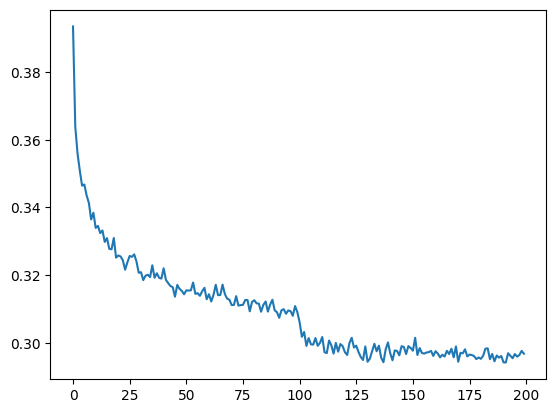

In [93]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [94]:
for layer in model.layers:
    layer.training = False

In [95]:
# evalyate the loss
@torch.no_grad() # disable gradient tracking automatically setting requires_grad to false
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr), 
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())
split_loss('train')
split_loss('val')

train 1.951467514038086
val 2.032949686050415


Our results are not so far from the previous: <br>
1. Our hyperparams for the new architecture are unexplored
2. BatchNorm needs to be re-adjusted for the new design

# Debugging BatchNorm

In [97]:
n_embd = 10
n_hidden = 68

model = Sequential([
    Embedding(vocab_size, n_embd),
    FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
])

with torch.no_grad():
    # make softmax (last layer) less confident
    layers[-1].weight *= 0.1


parameters = model.parameters()
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

22397


In [103]:
ix = torch.randint(0, Xtr.shape[0], (4,)) # looking at a batch of 4 examples
Xb, Yb, = Xtr[ix], Ytr[ix]
logits = model(Xb)
print(Xb.shape)
Xb

torch.Size([4, 8])


tensor([[ 0,  0,  0,  0,  0,  0,  0, 20],
        [ 0,  0,  0,  0,  0,  0, 11,  5],
        [ 0,  0,  0,  0,  0,  0, 13,  9],
        [ 0,  0, 20,  9,  5, 18, 18,  1]])

In [104]:
for layer in model.layers:
    print(layer.__class__.__name__, ':', tuple(layer.out.shape))

Embedding : (4, 8, 10)
FlattenConsecutive : (4, 4, 20)
Linear : (4, 4, 68)
BatchNorm1d : (4, 4, 68)
Tanh : (4, 4, 68)
FlattenConsecutive : (4, 2, 136)
Linear : (4, 2, 68)
BatchNorm1d : (4, 2, 68)
Tanh : (4, 2, 68)
FlattenConsecutive : (4, 136)
Linear : (4, 68)
BatchNorm1d : (4, 68)
Tanh : (4, 68)
Linear : (4, 27)


Looking at our previous implementation

In [ ]:
class BatchNorm1d:  
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps # epsilon
        self.momentum = momentum
        self.training = True # behaviours of certain attributes vary for training and inference
        # batchnorm trainable params
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers for running momentum update
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        # forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True) # batch mean
            xvar = x.var(0, keepdim=True) # batch variance
        else: # in inference, we use the accummuldated mean and var of the whole training set
            xmean = self.running_mean 
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        # update buffers - only updated during training
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 -self.momentum) * self.running_var + self.momentum * xvar
        return self.out
        
    def parameters(self):
        return [self.gamma, self.beta] 

The batchnorm receives an input (4,4,68) and assumes that x is 2 dim (which was the case in that implementation). This was properly broadcast, but it doesn't reflect the factual behaviour of batchnorm. <br> 

Let's inspect this

In [105]:
e = torch.randn(32, 4, 68)
emean = e.mean(0, keepdim=True)
evar = e.var(0, keepdim=True)
ehat = (e - emean) / torch.sqrt(evar + 1e-5)
ehat.shape

torch.Size([32, 4, 68])

The means are done over the first dimension (the 0 axis), giving us a mean and var that maintain the second and third dims ie emean and evar have shape (1,4,68) <br>
ehat then becomes a broadcast operation on the shape of e

If we compare the running mean of the model's batchnorm

In [106]:
model.layers[3].running_mean.shape

torch.Size([1, 4, 68])

On the implementation, self.running_mean = torch.zeros(dim) is supposed to be on 68 channels, but it is on 4*68 channels. <br>
We want our batch norm to average over 32*4 numbers for every single 68 channels

We can reduce over a tuple

In [107]:
e = torch.randn(32, 4, 68)
emean = e.mean((0,1), keepdim=True)
evar = e.var((0,1), keepdim=True)
ehat = (e - emean) / torch.sqrt(evar + 1e-5)
ehat.shape

torch.Size([32, 4, 68])

Our modified batchnorm becomes

In [108]:
class BatchNorm1d:  
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps # epsilon
        self.momentum = momentum
        self.training = True # behaviours of certain attributes vary for training and inference
        # batchnorm trainable params
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers for running momentum update
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        # forward pass
        if self.training:
            if x.ndim == 2:
                dim = 0
            elif x.ndim == 3:
                dim = (0,1)
            xmean = x.mean(dim, keepdim=True) # batch mean
            xvar = x.var(dim, keepdim=True) # batch variance
        else: # in inference, we use the accummuldated mean and var of the whole training set
            xmean = self.running_mean 
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        # update buffers - only updated during training
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 -self.momentum) * self.running_var + self.momentum * xvar
        return self.out
        
    def parameters(self):
        return [self.gamma, self.beta] 

And we retrain our neural net

In [109]:
n_embd = 10
n_hidden = 68

model = Sequential([
    Embedding(vocab_size, n_embd),
    FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
])

with torch.no_grad():
    # make softmax (last layer) less confident
    layers[-1].weight *= 0.1


parameters = model.parameters()
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

22397


In [110]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # Construct the minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)

    # backward pass
    for layer in layers:
        layer.out.retain_grad() # for debugging. retains the graphs
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())


      0/ 200000: 3.2498
  10000/ 200000: 2.2207
  20000/ 200000: 2.1400
  30000/ 200000: 2.2454
  40000/ 200000: 2.0046
  50000/ 200000: 2.3608
  60000/ 200000: 2.0525
  70000/ 200000: 1.9387
  80000/ 200000: 2.2600
  90000/ 200000: 1.7542
 100000/ 200000: 1.8051
 110000/ 200000: 1.7223
 120000/ 200000: 1.9126
 130000/ 200000: 1.7229
 140000/ 200000: 2.0629
 150000/ 200000: 1.9279
 160000/ 200000: 1.8189
 170000/ 200000: 1.5680
 180000/ 200000: 2.1662
 190000/ 200000: 1.9556


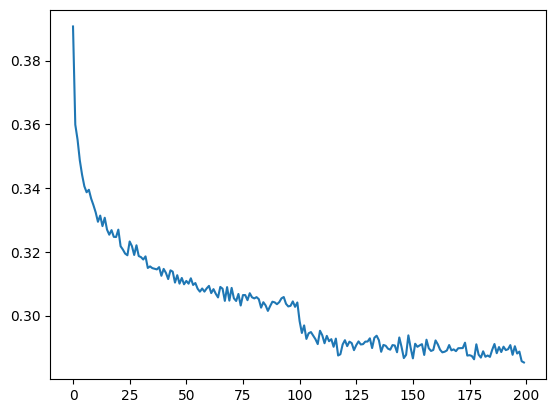

In [111]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [112]:
for layer in model.layers:
    layer.training = False

# evalyate the loss
@torch.no_grad() # disable gradient tracking automatically setting requires_grad to false
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr), 
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())
split_loss('train')
split_loss('val')

train 1.9253654479980469
val 2.025333881378174


# Improving WaveNet

We increase the size of the embedding and hidden layers

In [113]:
n_embd = 24
n_hidden = 128

model = Sequential([
    Embedding(vocab_size, n_embd),
    FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
])

with torch.no_grad():
    # make softmax (last layer) less confident
    layers[-1].weight *= 0.1


parameters = model.parameters()
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

76579


In [114]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # Construct the minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)

    # backward pass
    for layer in layers:
        layer.out.retain_grad() # for debugging. retains the graphs
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())


      0/ 200000: 3.3523
  10000/ 200000: 1.8479
  20000/ 200000: 2.1235
  30000/ 200000: 1.6730
  40000/ 200000: 1.8855
  50000/ 200000: 1.8947
  60000/ 200000: 1.4509
  70000/ 200000: 1.8790
  80000/ 200000: 1.5284
  90000/ 200000: 2.0600
 100000/ 200000: 1.8260
 110000/ 200000: 1.5428
 120000/ 200000: 1.7263
 130000/ 200000: 2.0242
 140000/ 200000: 1.4802
 150000/ 200000: 1.8521
 160000/ 200000: 1.5505
 170000/ 200000: 1.8442
 180000/ 200000: 2.0257
 190000/ 200000: 1.9244


In [115]:
for layer in model.layers:
    layer.training = False

# evalyate the loss
@torch.no_grad() # disable gradient tracking automatically setting requires_grad to false
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr), 
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())
split_loss('train')
split_loss('val')

train 1.7875323295593262
val 1.9884787797927856


With a larger architecture, we don't have an experimental harness that we can use to determine optimal hyperparams. We are sort of walking blindly and hoping for better performance. <br>

# A Brief Intro to Conv Layers

If we look at the design of the WaveNet, the arrow shows one possible operation to reduce into a single node of the final layer. <br>
Convolution allows sliding through the input sequence and calculating all the final nodes at the same time. <br>
The sliding is done in a theoretical 'for loop', but it is handle at the GPU level making it very efficient. 